# **Prediction of Score Improvement with Classification**

## Objectives

* Fit and evaluate a Classification model to predict if the student improves theire Exam Score.

## Inputs

* outputs/datasets/collection/StudentPerformance.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

<!-- * Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot -->


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance'

-------

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/StudentPerformance.csv")
      )

print(df.shape)
df.head(3)

(6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74


---

# ML Pipline Clasificasion

Importing the necessary libraries that will be used to create the different pipelines 

In [5]:
from sklearn.pipeline import Pipeline

# Cleaning
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel


## Create ML Pipline

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class CreateImprovedScoreColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X): 
        X = X.copy() # To avoid modifying the original data
        try:
            new_value = X['Exam_Score'] - X['Previous_Scores']
            X['Improved_Score'] = new_value

            # Replace negative and zero values with 0, positive values with 1
            X['Improved_Score'] = X['Improved_Score'].apply(lambda x: 1 if x > 0 else 0)
        
            # Drop the original columns Previous_Scores and Exam_Score
            X.drop(['Previous_Scores', 'Exam_Score'], axis=1, inplace=True)
        except Exception as e: 
            print(f'An error occored: {e}')
            

        return X

### ML pipeline for Data Cleaning and Feature Engineering

In [7]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('generat_improved_score', CreateImprovedScoreColumn()),
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

    ])

    return pipeline_base


### ML Pipeline for Modelling and Hyperparameters

In this section, we will also import the algorithms that will be used.

In [8]:
# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


----------

## Spliting the data

First, the dataset will be split into a training and test set. Before that, the dataset goes through a pipeline for cleaning and feature engineering.


In [10]:
from sklearn.model_selection import train_test_split
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
df_cleaned = pipeline_data_cleaning_feat_eng.fit_transform(df)

X = df_cleaned.drop(['Improved_Score'], axis=1)
y = df_cleaned['Improved_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5285, 18) (5285,) (1322, 18) (1322,)


### Check Train Set Target distribution

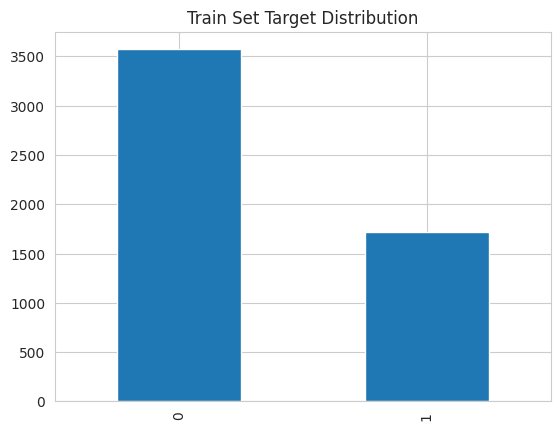

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [12]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7140, 18) (7140,) (1322, 18) (1322,)


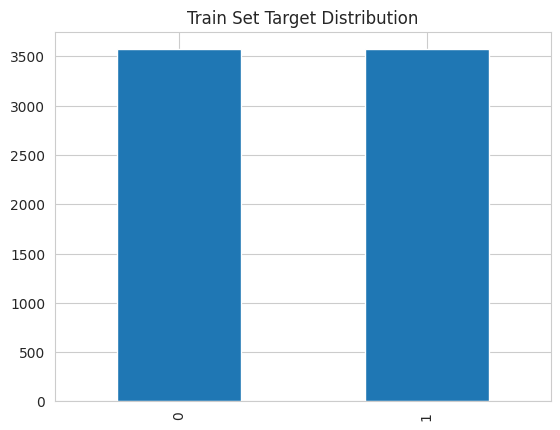

In [13]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

#### Conclusion
What to do Drop 0 or Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target?

---

## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm 

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

In [15]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
5,ExtraTreesClassifier,0.460784,0.665546,0.859944,0.177033
2,DecisionTreeClassifier,0.338936,0.640056,0.914566,0.245339
3,RandomForestClassifier,0.309524,0.639776,0.929972,0.271751
0,LogisticRegression,0.427171,0.62437,0.806723,0.162439
6,AdaBoostClassifier,0.0,0.496078,0.868347,0.323709
4,GradientBoostingClassifier,0.018207,0.468627,0.855742,0.365411
1,XGBClassifier,0.009804,0.411765,0.82493,0.321627


In [29]:
models_search = {
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}


params_search = {
    "ExtraTreesClassifier": {
        # Higher complexity and flexibility
        "model__max_depth": [None],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": [1, 0.8, 4],
        "model__random_state": [42],
        # Best score 0.72

        # # preventing overfitting
        # "model__max_depth": [10, 20, 30],
        # "model__min_samples_split": [5, 10],
        # "model__min_samples_leaf": [4, 10],
        # "model__max_features": [0.5, "sqrt"],
        # "model__max_leaf_nodes": [50, 100],
        # "model__random_state": [42]
        # # Best score 0.64

        # # Balaced accurcy and preformence
        # "model__criterion": ["gini", "entropy"],
        # "model__max_depth": [None, 10, 20],
        # "model__min_samples_split": [2, 5],
        # "model__min_samples_leaf": [1, 2, 4],
        # "model__max_features": ["sqrt", "log2"],
        # "model__random_state": [42],
        # # Best score 0,79
    }
}

In [30]:
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__random_state
9,ExtraTreesClassifier,0.67507,0.721569,0.794118,0.043812,None,4,1,5,42
4,ExtraTreesClassifier,0.677871,0.721289,0.77591,0.03563,None,0.8,1,2,42
5,ExtraTreesClassifier,0.665266,0.720168,0.79972,0.04768,None,0.8,1,5,42
8,ExtraTreesClassifier,0.672269,0.719608,0.789916,0.041608,None,4,1,2,42
7,ExtraTreesClassifier,0.656863,0.713725,0.791317,0.04827,None,0.8,2,5,42
0,ExtraTreesClassifier,0.666667,0.711204,0.77451,0.03617,None,1,1,2,42
1,ExtraTreesClassifier,0.663866,0.705882,0.778711,0.039266,None,1,1,5,42
6,ExtraTreesClassifier,0.659664,0.703361,0.768908,0.040159,None,0.8,2,2,42
11,ExtraTreesClassifier,0.654062,0.69916,0.770308,0.041352,None,4,2,5,42
10,ExtraTreesClassifier,0.654062,0.697199,0.768908,0.041711,None,4,2,2,42


### Quick conclusion

In the first attempt, the target distribution was not corrected, resulting in a maximum outcome of only 0.34 for the different algorithms. This suggests that the target distribution needs to be more balanced for the algorithms to achieve a higher mean score.

-------

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
